# xAI in cancer medicine: Predict Drug Response (AAC) through Support Vector Regression

In [83]:
%load_ext autoreload
%autoreload 2

# Imports
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression

# Added to be able to display multiple dataframe in same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
# Matplotlib config: Enable LaTeX rendering in the plots
plt.rcParams.update({
    "text.usetex": True, 
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
})

In [85]:
# Set up the constants
SEED = 42
TEST_SIZE = 0.2

## 1. Data loading

In [116]:
# Boolean stating if we use the augmented data or the competition one
withAugmentedData = False

In [122]:
# Load competition data from the CSV files
DATA_PATH = 'data'

if not withAugmentedData:
    X = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'), index_col=0)
    X_submission = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'), index_col=0)
    X_submission.index = X_submission.index.map(lambda x: x.replace("CL", "TS"))
    y = pd.read_csv(os.path.join(DATA_PATH, 'train_targets.csv'), index_col=0)
    y = y['AAC']
    
else:
    X = pd.read_csv(os.path.join(DATA_PATH, 'train_augmented.csv'), index_col=0)
    X_submission = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'), index_col=0)
    X_submission.index = X_submission.index.map(lambda x: x.replace("CL", "TS"))
    intersection = X.columns.intersection(X_submission.columns)
    X = X.loc[:, intersection]
    X_submission = X_submission.loc[:, intersection]
    print(X_submission.head())
    y = pd.read_csv(os.path.join(DATA_PATH, 'train_targets_augmented.csv'), index_col=0)
    y = y['AAC']

    X_test_partition = pd.read_csv(os.path.join(DATA_PATH, 'x_test_partition.csv'), index_col=0)
    X_test_partition = X_test_partition.loc[:, intersection]
    y_test_partition = pd.read_csv(os.path.join(DATA_PATH, 'y_test_partition.csv'), index_col=0)
    y_test_partition = y_test_partition['AAC']

In [123]:
# Display the first few rows of each dataset for inspection
print("Head of the X dataframe (features): shape = {}".format(X.shape))
X.head()

print('\n\n')
print("Head of the X_predict dataframe (test features): shape = {}".format(X_submission.shape))
X_submission.head()

print('\n\n')
print("Head of the y dataframe (labels): shape = {}".format(y.shape))
y.head()

Head of the X dataframe (features): shape = (742, 19920)


,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
CL1,1.672481,45.412546,9.377504,0.860362,0.156075,0.358733,0.013006,90.484463,119.760414,0.000000,...,38.069286,118.897181,201.401740,2.789229,13.546617,40.176298,0.832672,54.266923,27.312810,74.123751
CL2,0.545643,15.886006,0.126553,0.731387,0.000000,3.006263,0.015819,43.455131,37.971081,0.015819,...,40.892433,72.780020,95.990439,4.139704,23.717772,40.655146,0.547275,45.944219,59.511226,66.289158
CL3,1.652956,0.464895,0.353668,0.196430,0.000000,11.393572,0.408079,86.349518,35.893872,0.040808,...,14.024315,33.830939,59.865191,15.289432,18.649139,20.009474,1.570321,23.104745,124.843779,61.950056
CL4,0.795200,0.182806,0.534622,0.239157,0.027417,20.203002,0.342707,74.806003,56.297983,0.027417,...,18.122326,56.826586,120.221485,16.671474,19.477221,25.798955,4.028667,22.369665,138.546988,69.946391
CL5,9.983922,0.222700,0.451019,0.152793,0.233698,1.174855,0.068735,53.228255,36.978543,0.068735,...,47.234577,63.179324,89.121585,1.397236,4.197779,16.001469,0.097534,32.175188,176.770218,62.978656





Head of the X_predict dataframe (test features): shape = (304, 19920)


,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
TS1,1.446057,75.700445,0.031116,0.471972,0.014860,3.129831,0.000000,54.031837,130.140472,0.000000,...,27.105080,39.252909,27.238822,3.305222,20.211109,103.382698,0.263830,22.459802,37.039151,143.833393
TS2,7.201269,0.354029,0.074407,0.453273,0.108228,11.557571,0.344976,43.575264,45.155525,0.060878,...,24.459509,20.147702,4.051783,7.994292,30.507789,30.844956,18.978149,88.545037,110.433059,32.066500
TS3,6.835308,0.121081,0.000000,0.211975,0.020079,12.372666,0.066928,34.581955,37.123022,0.000000,...,14.771119,27.387161,21.477355,6.518653,25.091676,29.635939,7.931413,73.418524,282.685845,77.289198
TS4,6.384288,0.132942,0.018201,0.207608,0.007283,4.364313,0.203914,49.908053,36.949086,2.672735,...,26.690940,18.067079,27.841600,3.410666,12.014003,28.533453,0.883263,36.657930,198.743729,69.446998
TS5,4.538481,1.354367,0.007254,0.237628,0.021695,3.881963,0.267576,39.319195,55.127152,0.036159,...,33.244498,49.214787,61.607545,8.412126,28.404872,19.482419,16.771958,46.033522,196.559752,36.681241





Head of the y dataframe (labels): shape = (742,)


sample
CL1    0.050705
CL2    0.163113
CL3    0.236655
CL4    0.270218
CL5    0.071619
Name: AAC, dtype: float64

## 2. Pipeline setup and Training

In [124]:
# Split the data into training and testing sets
if withAugmentedData:
    X_train, X_test, y_train, y_test = X, X_test_partition, y, y_test_partition
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)

# List of pipelines for SVR with different kernels and parameters
pipelines = [
    # Pipeline 0: SVR with RBF kernel, default parameters
    Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', SVR(kernel='rbf', C=1.0, gamma='scale'))
    ]),
    
    # Pipeline 1: SVR with RBF kernel and higher regularization
    Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', SVR(kernel='rbf', C=10.0, gamma='scale'))
    ]),
    
    # Pipeline 2: SVR with RBF kernel and lower regularization
    Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', SVR(kernel='rbf', C=0.1, gamma='scale'))
    ]),
    
    # Pipeline 3: SVR with polynomial kernel, default parameters
    Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', SVR(kernel='poly', degree=3, C=1.0, gamma='scale'))
    ]),
    
    # Pipeline 4: SVR with linear kernel, default parameters
    Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', SVR(kernel='linear', C=1.0, epsilon=0.1))
    ]),
    
    # Pipeline 5: SVR with RBF kernel and smaller epsilon (tighter fit)
    Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', SVR(kernel='rbf', C=1.0, gamma='scale', epsilon=0.01))
    ]),

     # Pipeline 6: SVR with linear kernel and higher regularization
    Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', SVR(kernel='linear', C=10.0, epsilon=0.1))
    ]),
    
    # Pipeline 7: SVR with linear kernel and lower regularization
    Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', SVR(kernel='linear', C=0.1, epsilon=0.1))
    ]),
    
    # Pipeline 8: SVR with linear kernel and smaller epsilon (tighter fit)
    Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', SVR(kernel='linear', C=1.0, epsilon=0.01))
    ]),
    
    # Pipeline 9: SVR with linear kernel and larger epsilon (looser fit)
    Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', SVR(kernel='linear', C=1.0, epsilon=1.0))
    ]),
    
    # Pipeline 10: SVR with linear kernel and larger tolerance for convergence
    Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', SVR(kernel='linear', C=1.0, epsilon=0.1, tol=1e-2))
    ]),

    # Pipeline 11: SVR with linear kernel and PCA for dimensionality reduction
    Pipeline([
        ('scaler', StandardScaler()), 
        ('pca', PCA(n_components=500)), 
        ('regressor', SVR(kernel='linear', C=1.0, epsilon=0.1))
    ]),

    # Pipeline 12: SVR with linear kernel with a tad looser fit
    Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', SVR(kernel='linear', C=1.0, epsilon=0.15, tol=1e-3))
    ]),

    # Pipeline 13: SVR with linear kernel with a tad looser fit 2
    Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', SVR(kernel='linear', C=1.0, epsilon=0.2, tol=1e-3))
    ]),

    # Pipeline 14: SVR with linear kernel with a tad looser fit 3
    Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', SVR(kernel='linear', C=1.0, epsilon=0.25, tol=1e-3))
    ]),

    # Pipeline 15: SVR with linear kernel with a tad looser fit 4
    Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', SVR(kernel='linear', C=1.0, epsilon=0.18, tol=1e-3))
    ]),

    # Pipeline 16: SVR with linear kernel with a tad looser fit and larger tolerance for convergence
    Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', SVR(kernel='linear', C=1.0, epsilon=0.18, tol=1e-1))
    ]),

    # Pipeline 17: SVR with linear kernel with a tad looser and less regularization
    Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', SVR(kernel='linear', C=10, epsilon=0.18, tol=1e-3))
    ]),

     # Pipeline 18: SVR with linear kernel with a tad looser and much more regularization
    Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', SVR(kernel='linear', C=0.00001, epsilon=0.18, tol=1e-3))
    ]),
    
    # Pipeline 19: SVR with polynomial kernel with degree 2
    Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', SVR(kernel='poly', degree=2, C=1.0, gamma='auto'))
    ]),

    # Pipeline 20: Best SVR with linear kernel with small epsilon change
    Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', SVR(kernel='linear', C=1.0, epsilon=0.17, tol=1e-3))
    ]),

    # Pipeline 21: Best SVR with linear kernel with small epsilon change 2
    Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', SVR(kernel='linear', C=1.0, epsilon=0.16, tol=1e-3))
    ]),

    # Pipeline 22: Best SVR with linear kernel without standardization
    Pipeline([
        ('regressor', SVR(kernel='linear', C=1.0, epsilon=0.17, tol=1e-3))
    ]),

    # Pipeline 23: SVR with default sigmoid kernel
    Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', SVR(kernel='sigmoid'))
    ]),

    # Pipeline 24: SVR with sigmoid kernel and best epsilon
    Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', SVR(kernel='sigmoid', C=1.0, epsilon=0.17, tol=1e-3, gamma='scale'))
    ]),

    # Pipeline 25: SVR with sigmoid kernel, test epsilon and auto gamma
    Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', SVR(kernel='sigmoid', C=1.0, epsilon=0.17, tol=1e-3, gamma='auto'))
    ]),

    # Pipeline 26: SVR with sigmoid kernel, test epsilon and auto gamma
    Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', SVR(kernel='sigmoid', C=1.0, epsilon=0.2, tol=1e-3, gamma='auto'))
    ]),

    # Pipeline 27: SVR with sigmoid kernel, test epsilon and auto gamma
    Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', SVR(kernel='sigmoid', C=1.0, epsilon=0.23, tol=1e-3, gamma='auto'))
    ]),

    # Pipeline 28: SVR with sigmoid kernel, test epsilon and auto gamma
    Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', SVR(kernel='sigmoid', C=1.0, epsilon=0.21, tol=1e-3, gamma='auto'))
    ]),

    # Pipeline 29: Best SVR with sigmoid kernel with stronger regularization
    Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', SVR(kernel='sigmoid', C=0.5, epsilon=0.23, tol=1e-3, gamma='auto'))
    ]),

    # Pipeline 30: Best SVR with SelectKBest feature selection k=500
    Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selector', SelectKBest(score_func=f_regression, k=500)),
        ('regressor', SVR(kernel='linear', C=1.0, epsilon=0.17, tol=1e-3))
    ]),

    # Pipeline 31: Best SVR with SelectKBest feature selection k=250
    Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selector', SelectKBest(score_func=f_regression, k=250)),
        ('regressor', SVR(kernel='linear', C=1.0, epsilon=0.17, tol=1e-3))
    ]),

    # Pipeline 32: Best SVR with SelectKBest feature selection k=500 and different epsilon
    Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selector', SelectKBest(score_func=f_regression, k=500)),
        ('regressor', SVR(kernel='linear', C=1.0, epsilon=0.25, tol=1e-3))
    ]),

    # Pipeline 33: Best SVR with SelectKBest feature selection k=500 and different epsilon
    Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selector', SelectKBest(score_func=f_regression, k=500)),
        ('regressor', SVR(kernel='linear', C=1.0, epsilon=0.35, tol=1e-3))
    ]),

    # Pipeline 34: Best SVR with SelectKBest feature selection k=500 and different epsilon
    Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selector', SelectKBest(score_func=f_regression, k=500)),
        ('regressor', SVR(kernel='linear', C=1.0, epsilon=0.30, tol=1e-3))
    ]),

    # Pipeline 35: Best SVR with SelectKBest feature selection k=1500 and different epsilon
    Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selector', SelectKBest(score_func=f_regression, k=1500)),
        ('regressor', SVR(kernel='linear', C=1.0, epsilon=0.2, tol=1e-3))
    ]),

    # Pipeline 36: Best SVR with SelectKBest feature selection k=1500 and different epsilon
    Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selector', SelectKBest(score_func=f_regression, k=1500)),
        ('regressor', SVR(kernel='linear', C=1.0, epsilon=0.25, tol=1e-3))
    ]),

    # Pipeline 37: Best SVR with SelectKBest feature selection k=1500 and different epsilon
    Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selector', SelectKBest(score_func=f_regression, k=1500)),
        ('regressor', SVR(kernel='linear', C=1.0, epsilon=0.1, tol=1e-3))
    ]),

    # Pipeline 38: Best SVR with SelectKBest feature selection k=2000 and different epsilon
    Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selector', SelectKBest(score_func=f_regression, k=2000)),
        ('regressor', SVR(kernel='linear', C=1.0, epsilon=0.22, tol=1e-3))
    ]),

    # Pipeline 39: Best SVR with SelectKBest feature selection k=500 and different epsilon
    Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selector', SelectKBest(score_func=f_regression, k=500)),
        ('regressor', SVR(kernel='linear', C=1.0, epsilon=0.28, tol=1e-3))
    ]),
]

In [125]:
# Choose a pipeline
pipeline_number = 15
pipeline = pipelines[pipeline_number]

# Train the pipeline
pipeline.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', SVR(epsilon=0.18, kernel='linear'))])

## 3. Model Evaluation

In [126]:
# Predict on training and testing sets
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Evaluate the model
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# Compute Spearman correlation
spearman_corr, _ = spearmanr(y_test, y_test_pred)

print(f"Train MSE: {train_mse:.5f}")
print(f"Test MSE: {test_mse:.5f}")
print(f"Spearman correlation: {spearman_corr:.5f}")

Train MSE: 0.01194
Test MSE: 0.01406
Spearman correlation: 0.30004


## 4. Prediction Visualization

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'True Values')

Text(0, 0.5, 'Predicted Values')

Text(0.5, 1.0, '\\textsc{Drug Response (AAC): Predicted vs True Values}\n\\textsc{Best Linear SVR with $\\epsilon=0.18$}')

Text(0.05, 0.95, "Test Spearman's $\\sigma_t$ = 0.3000")

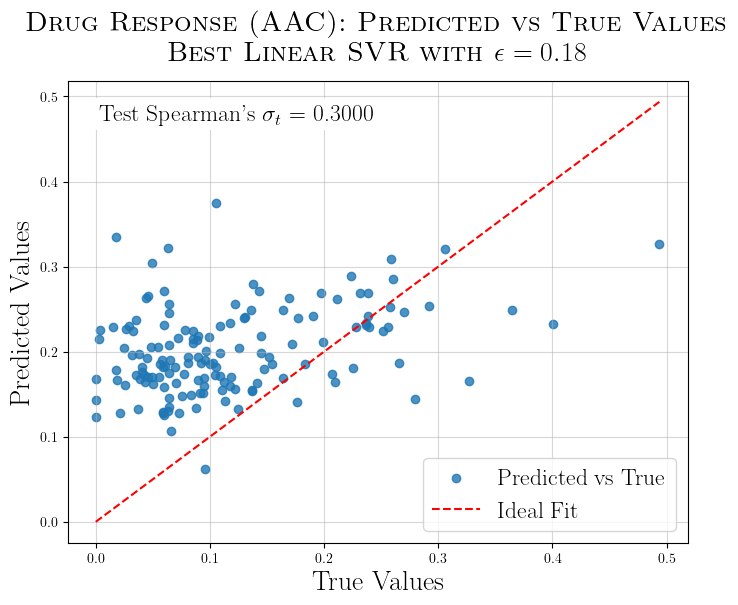

In [127]:
# Visualize predictions vs true values for test data
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.8, label='Predicted vs True')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('True Values', fontsize=20)
plt.ylabel('Predicted Values', fontsize=20)
plt.title(r"\textsc{Drug Response (AAC): Predicted vs True Values}"+ "\n" + r"\textsc{Best Linear SVR with $\epsilon=0.18$}", fontsize=20, pad=15)
plt.text(0.05, 0.95, f"Test Spearman's $\sigma_t$ = {spearman_corr:.4f}", 
         transform=plt.gca().transAxes, fontsize=17, 
         verticalalignment='top', bbox=dict(facecolor='white', edgecolor='none'))
plt.legend(fontsize=17, loc='lower right')
plt.grid(alpha=0.5)
plt.savefig('SVR_Predicted_vs_True.pdf', bbox_inches='tight')
plt.show() 

## 5. Prepare Submission for Competition

In [109]:
# Create a submissions folder
SUBMISSION_PATH = "submissions"
os.makedirs(SUBMISSION_PATH, exist_ok=True)

# Predict on the feature set for submission
y_submission = pipeline.predict(X_submission)

# Format predictions and save to csv
submission = pd.DataFrame({"sampleId": X_submission.index, "AAC": y_submission})
submission.to_csv(os.path.join(SUBMISSION_PATH, f'SVR_pipeline_{pipeline_number}{"_augmented" if withAugmentedData else ""}.csv'), index=False)

## 6. Hyperparameter tuning with GridSearch and Cross Validation

In [ ]:
# Pipeline whose hyperparameters are tuned through GridSearchCV to get best results locally

# Helper function
def spearman_scorer(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

# MSE or Spearman as scoring metrics
scoring = {
    'MSE': 'neg_mean_squared_error',
    'Spearman': make_scorer(spearman_scorer)
}

# Define parameter grid for GridSearchCV
param_grid = [
    {
        'regressor__kernel': ['linear'],
        'regressor__C': [0.01, 0.1, 1, 10],
        'regressor__epsilon': [0.01, 0.05, 0.1, 0.15, 0.2], 
    },
    
    {
        'regressor__kernel': ['sigmoid'],
        'regressor__C': [0.01, 0.1, 1, 10],
        'regressor__epsilon': [0.01, 0.05, 0.1, 0.15, 0.2],
        'regressor__gamma': ['scale', 'auto'],
    }
]

base_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', SVR())
])

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=base_pipeline,
    param_grid=param_grid,
    scoring=scoring,
    refit='Spearman',
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train.values.ravel())

# Display the best parameters and results
print("Best parameters:", grid_search.best_params_)
print("Best Spearman score obtained during cross-validation on the training set:", grid_search.best_score_)

# Evaluate on test data
y_test_pred = grid_search.best_estimator_.predict(X_test)
test_spearman = spearmanr(y_test, y_test_pred).correlation
test_mse = mean_squared_error(y_test, y_test_pred)

print("Test Spearman Correlation:", test_spearman)
print("Test MSE:", test_mse)

# Predict on the feature set for submission
y_submission = grid_search.best_estimator_.predict(X_submission)

# Format predictions and save to csv
submission = pd.DataFrame({"sampleId": X_submission.index, "AAC": y_submission})
submission.to_csv(os.path.join(SUBMISSION_PATH, f'SVR_GridSearchCV.csv'), index=False)